# SARIMA
- Energy Consumption
- https://www.kaggle.com/robikscube/hourly-energy-consumption
- DAYTON_hourly.csv

## Setting up

In [1]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# kpss_test
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# Data preparation

## Load data

In [2]:
import pandas as pd
df_all = pd.read_csv('DAYTON_hourly.csv')
df_all.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [3]:
df_all['Datetime'] = pd.to_datetime(df_all['Datetime'])
df = df_all.set_index('Datetime')
df.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


In [4]:
df.describe()

,DAYTON_MW
count,121275.000000
mean,2037.851140
std,393.403153
min,982.000000
25%,1749.000000
50%,2009.000000
75%,2279.000000
max,3746.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121275 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   DAYTON_MW  121275 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


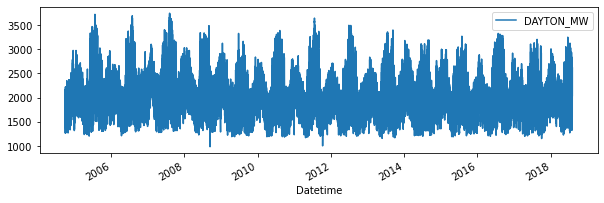

In [6]:
import matplotlib.pyplot as plt
df.plot(figsize=(10, 3))
plt.show()

## Resample data

In [7]:
max_sample = 365
#df_avg = df['DAYTON_MW'].resample('MS').mean()
df_avg = df['DAYTON_MW'].resample('D').mean()
if max_sample > 0:
    df_avg = df_avg.iloc[-max_sample-1:-1]
display(df_avg.describe())

count     365.000000
mean     2027.813333
std       260.979131
min      1407.166667
25%      1835.416667
50%      2008.708333
75%      2199.791667
max      2796.583333
Name: DAYTON_MW, dtype: float64

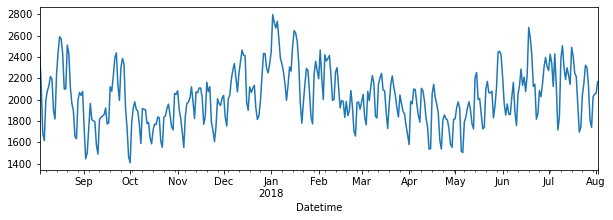

In [8]:
df_avg.plot(figsize=(10, 3))
plt.show()

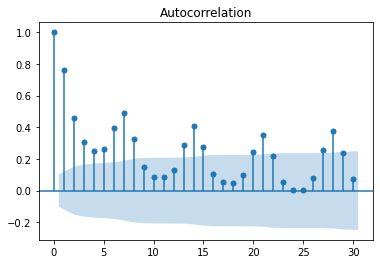

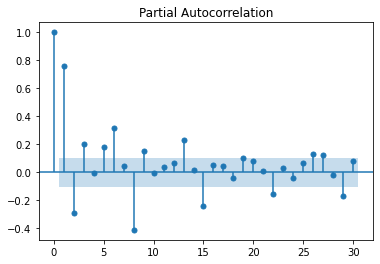

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_avg, lags=30)
plot_pacf(df_avg, lags=30)
plt.show()

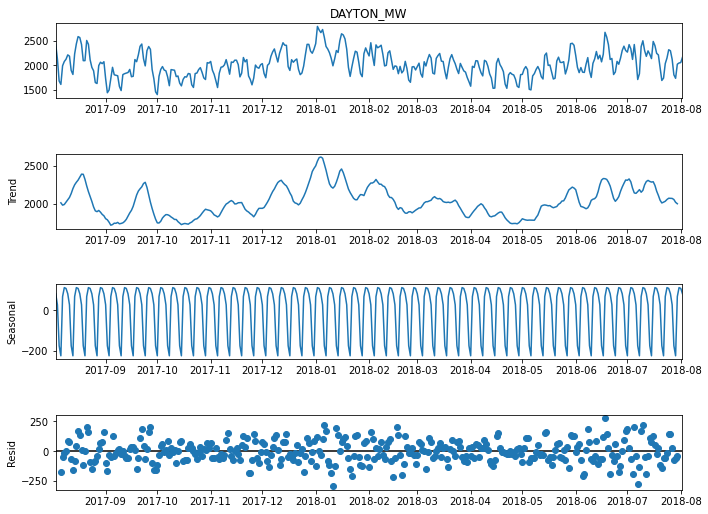

In [10]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df_avg, model='additive')
fig = decomposition.plot()
fig.set_size_inches(11,8)

In [11]:
adf_test(df_avg)
kpss_test(df_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.308630
p-value                          0.014497
#Lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64
Results of KPSS Test:
Test Statistic            0.175163
p-value                   0.100000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
C:\Users\admin\miniconda3\envs\pythonclass\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length

## Test for stationariy and seasonality

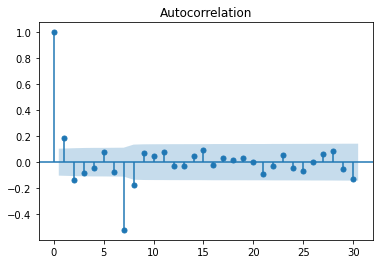

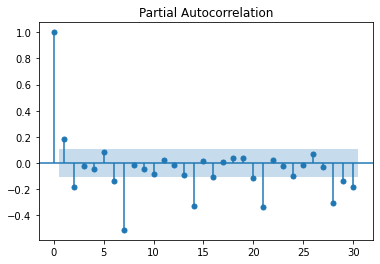

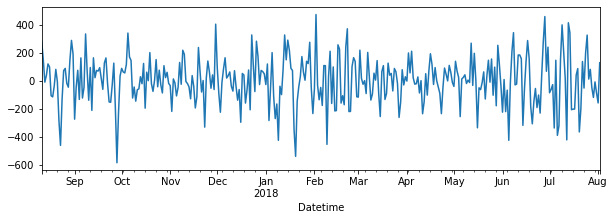

Results of Dickey-Fuller Test:
Test Statistic                -9.796062e+00
p-value                        6.170015e-17
#Lags Used                     1.300000e+01
Number of Observations Used    3.430000e+02
Critical Value (1%)           -3.449560e+00
Critical Value (5%)           -2.870004e+00
Critical Value (10%)          -2.571279e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.03574
p-value                   0.10000
Lags Used                17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64
C:\Users\admin\miniconda3\envs\pythonclass\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag

In [12]:
df_diff = df_avg.diff(1).diff(7).dropna()
plot_acf(df_diff, lags=30)
plot_pacf(df_diff, lags=30)
fig, ax = plt.subplots(figsize=(10, 3))
df_diff.plot(ax=ax)
plt.show()
adf_test(df_diff)
kpss_test(df_diff)

# Model selection

In [13]:
import itertools
p = [0,1,2]
d = [1]
q = [0,1,2]
P = [0,1]
D = [1]
Q = [0,1]
lag = [7]
params = list(itertools.product(p, d, q, P, D, Q, lag))
print(f"Number of models to test: {len(params)}")

Number of models to test: 36


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
df_results = pd.DataFrame()
for param in params:
    pdq = param[0:3]
    PDQL = param[3:7]
    try:
        mod = SARIMAX(df_avg, order=pdq, seasonal_order=PDQL)
        results = mod.fit(method = 'powell',start_params=np.random.random(7))
        data = {'param': pdq, 'param_seasonal': PDQL, 'AIC':results.aic }
        df_results = df_results.append(data, ignore_index=True)
    except:
        continue
df_results = df_results.sort_values(by='AIC',ascending=True)

Optimization terminated successfully.
         Current function value: 6.398274
         Iterations: 2
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: 6.068673
         Iterations: 2
         Function evaluations: 314
Optimization terminated successfully.
         Current function value: 6.242363
         Iterations: 2
         Function evaluations: 193
Optimization terminated successfully.
         Current function value: 6.066800
         Iterations: 4
         Function evaluations: 435
Optimization terminated successfully.
         Current function value: 6.373997
         Iterations: 2
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 6.059275
         Iterations: 3
         Function evaluations: 336
Optimization terminated successfully.
         Current function value: 6.228268
         Iterations: 3
         Function evaluations: 271
Optimization terminated successful

In [15]:
df_results

,AIC,param,param_seasonal
23,4409.890032,"(1, 1, 2)","(1, 1, 1, 7)"
25,4428.539031,"(2, 1, 0)","(0, 1, 1, 7)"
9,4429.333240,"(0, 1, 2)","(0, 1, 1, 7)"
21,4429.707831,"(1, 1, 2)","(0, 1, 1, 7)"
19,4432.588205,"(1, 1, 1)","(1, 1, 1, 7)"
29,4433.038575,"(2, 1, 1)","(0, 1, 1, 7)"
31,4433.512439,"(2, 1, 2)","(0, 1, 1, 7)"
17,4433.878946,"(1, 1, 1)","(0, 1, 1, 7)"
7,4436.838545,"(0, 1, 1)","(1, 1, 1, 7)"
5,4437.270849,"(0, 1, 1)","(0, 1, 1, 7)"


# Model training

In [16]:
rank = 1
pdq = df_results.iloc[rank-1,1]
PDQL = df_results.iloc[rank-1,2]

print(f"Using ({pdq[0]},{pdq[1]},{pdq[2]})({PDQL[0]},{PDQL[1]},{PDQL[2]},{PDQL[3]})")

mod = SARIMAX(df_avg, order=pdq, seasonal_order=PDQL)
results = mod.fit(method = 'powell', start_params=np.random.random(7))

Using (1,1,2)(1,1,1,7)
Optimization terminated successfully.
         Current function value: 6.052582
         Iterations: 3
         Function evaluations: 333


# Model evaluation

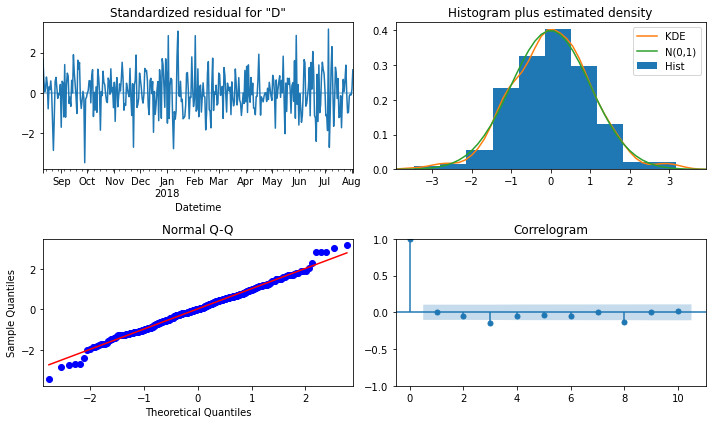

In [17]:
fig = results.plot_diagnostics(figsize=(10, 6))
fig.tight_layout()

In [18]:
pred = results.get_prediction(start=df_avg.index[1], end=df_avg.index[-1], dynamic=False)
comb = pd.concat([df_avg, pred.predicted_mean], axis=1).dropna()
comb['error'] = comb.iloc[:,0] - comb.iloc[:,1]
comb['percentage'] = comb['error']/comb.iloc[:,0]*100

MAE = comb['error'].abs().mean()
RMSE = np.sqrt((comb['error']**2).mean())
MAPE = comb['percentage'].abs().mean()

print(f"Mean absolute error: {MAE:6.3f}")
print(f"Root mean squared error: {RMSE:6.3f}")
print(f"Mean absolute percentage error: {MAPE:6.3f}")

Mean absolute error: 96.715
Root mean squared error: 135.597
Mean absolute percentage error:  4.736


# Plotting and forecasting

In [19]:
num_forecast = 10

start_dt = df_avg.index[10]
end_dt_data = df_avg.index[-1]
if num_forecast > 0:
    end_dt = end_dt_data + num_forecast * end_dt_data.freq
else:
    end_dt = end_dt_data

print(start_dt)
print(end_dt)

2017-08-13 00:00:00
2018-08-12 00:00:00


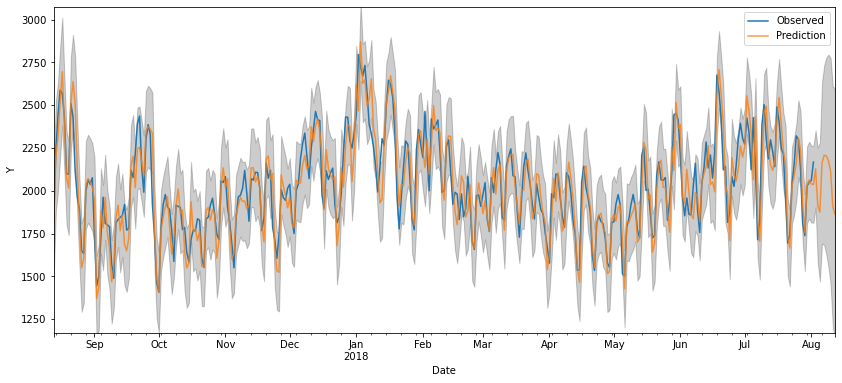

In [20]:
pred = results.get_prediction(start=pd.to_datetime(start_dt), end=pd.to_datetime(end_dt), dynamic=False)
pred_ci = pred.conf_int()
ax = df_avg.plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=.8, figsize=(14, 6))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Y')
ax.set_xlim(start_dt,end_dt)
yp_max = pred.predicted_mean.max()
yp_min = pred.predicted_mean.min()
yp_mean = pred.predicted_mean.mean()
ax.set_ylim(yp_min-0.1*yp_mean,yp_max+0.1*yp_mean)
plt.legend()
plt.show()

In [21]:
if num_forecast > 0:
    display(pred.predicted_mean.loc[end_dt_data:end_dt])

2018-08-02    2037.494957
2018-08-03    2128.408319
2018-08-04    1915.516353
2018-08-05    1876.287422
2018-08-06    2163.180572
2018-08-07    2208.102776
2018-08-08    2203.581433
2018-08-09    2174.638011
2018-08-10    2115.411001
2018-08-11    1910.439338
2018-08-12    1863.448374
Freq: D, Name: predicted_mean, dtype: float64